In [0]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [0]:
df = yf.download("^FTSE", start="2010-10-01", end="2017-09-30")
df = df[["Open", "High", "Low", "Adj Close"]]
df.columns = "open high low close".split()
df.head()


[*********************100%***********************]  1 of 1 completed


,open,high,low,close
Date,,,,
2010-10-01,5548.600098,5615.100098,5547.600098,5592.899902
2010-10-04,5592.899902,5601.200195,5550.799805,5556.000000
2010-10-05,5556.000000,5646.100098,5550.600098,5635.799805
2010-10-06,5635.799805,5695.500000,5635.799805,5681.399902
2010-10-07,5681.399902,5707.299805,5650.799805,5662.100098


## Add feature columns

In [0]:
# Set k = 5
k = 5
df["return"] = np.log(df["close"]/df["close"].shift(1))
df["momentum"] = df["close"] - df["close"].shift(k)
df["SMA"] = df["close"].rolling(k).mean()
df["EMA"] = pd.Series.ewm(df['close'], span=k).mean()
df["return_sign"] = np.where(df["close"]  - df["close"].shift(1) > 0, 1, -1)
df["std"] = df["return"].rolling(k).std()

# Drop the NaN values
df = df.dropna()
df.head(5)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,open,high,low,close,return,momentum,SMA,EMA,return_sign,std
Date,,,,,,,,,,
2010-10-08,5662.100098,5663.700195,5606.600098,5657.600098,-0.000795,64.700195,5638.579980,5649.754303,-1,0.008630
2010-10-11,5657.600098,5686.000000,5655.700195,5672.399902,0.002613,116.399902,5661.859961,5657.772099,1,0.007095
2010-10-12,5672.399902,5677.000000,5597.500000,5661.600098,-0.001906,25.800293,5667.020020,5659.099908,-1,0.004567
2010-10-13,5661.600098,5760.500000,5661.600098,5747.399902,0.015041,66.000000,5680.220020,5689.319315,1,0.007454
2010-10-14,5747.399902,5770.899902,5712.899902,5727.200195,-0.003521,65.100098,5693.240039,5702.169110,-1,0.007476


## Split the dataset

Split dataset into $X$ and $y$

In [0]:
cols = [c for c in df.columns if c != "return_sign"]
label = "return_sign"
print(cols)
label

['open', 'high', 'low', 'close', 'return', 'momentum', 'SMA', 'EMA', 'std']


'return_sign'

In [0]:
X = df[cols]
orig_column_names = X.columns
y = df[label]

### Scale your dataset

In [0]:
from sklearn.preprocessing import scale

X = scale(X)
X

array([[-1.23944342, -1.31546652, -1.25408067, ..., -1.28455326,
        -1.26714383,  0.07065808],
       [-1.24729762, -1.27612693, -1.16944629, ..., -1.24373803,
        -1.25306264, -0.23789512],
       [-1.22146638, -1.29200403, -1.2697666 , ..., -1.23469125,
        -1.25073069, -0.74624201],
       ...,
       [ 1.59435177,  1.61968014,  1.64020242, ...,  1.61953664,
         1.62714452, -0.90867131],
       [ 1.64287293,  1.61227048,  1.64726896, ...,  1.64018969,
         1.64180617, -0.95129061],
       [ 1.6591046 ,  1.71706004,  1.70208347, ...,  1.6619998 ,
         1.6808513 , -0.92400393]])

### Split further

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

### A.1 Logistic Regression and Bayesian Classifier

### First fit with L1 cost function


$log(\frac{p(X)}{1 - p(X)}) = \beta_0 + \beta_1$

```
# This is formatted as code
```



## Score the model

In [0]:
from sklearn.linear_model import LogisticRegression

l1_clf = LogisticRegression(solver = "liblinear", penalty = 'l1')
model_l1 = l1_clf.fit(X_train, y_train)

In [0]:
model_l1.score(X_test, y_test)

l1_w = l1_clf.coef_

### Now, fit with L2

In [0]:
l2_clf = LogisticRegression(solver = "liblinear", penalty = "l2")
model_l2 = l2_clf.fit(X_train, y_train)

In [0]:
model_l2.score(X_test, y_test)

0.9848197343453511

In [0]:
from sklearn.linear_model import LogisticRegression

l2_clf = LogisticRegression()
model_l2 = l1_clf.fit(X_train, y_train)

In [0]:
l2_w = model_l2.coef_

### Compare the weights between L1 and L2

In [0]:
l1_w_df = pd.DataFrame(l1_w)
l1_w_df.columns = orig_column_names
print("L1 Logit Weights")
l1_w_df

L1 Logit Weights


,open,high,low,close,return,momentum,SMA,EMA,std
0,0.0,0.0,0.0,0.0,33.53348,0.321779,0.0,0.0,0.0


In [0]:
l2_w_df = pd.DataFrame(l2_w)
l2_w_df.columns = orig_column_names
print("L2 Logit Weights")
l2_w_df

L2 Logit Weights


,open,high,low,close,return,momentum,SMA,EMA,std
0,0.0,0.0,0.0,0.0,33.531392,0.321956,0.0,0.0,0.0


Some of the features where given 0 weight, i.e redundant because both Lasso and Ridge regression penalize excessive use of weights. This also helps us reduce Bias.

What was left where weights that were almost equal to each other

In [0]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

kf = KFold(shuffle = True)

l1_logReg = LogisticRegression(solver = "liblinear", penalty = "l1")

results = cross_val_score(l1_logReg, X_train, y_train, cv=kf)
l1_pred = cross_val_predict(l1_logReg, X_test, y_test, cv = kf)
results

array([1.        , 0.99593496, 1.        , 0.99593496, 0.99591837])

### B1. Confusion Matrix and ROC Curve

In [0]:
from sklearn.metrics import confusion_matrix

l1_cm = confusion_matrix(y_test, l1_pred)
l1_cm

array([[247,   2],
       [  4, 274]])

In [0]:
from sklearn.metrics import roc_auc_score, roc_curve

l1_ROC_auc = roc_auc_score(y_test, l1_pred)
fpr, tpr, threshold = roc_curve(y_test, l1_pred)

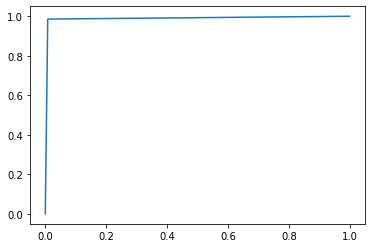

In [0]:
plt.figure()
plt.plot(fpr, tpr, label = "Logitistic Regression (l1) {}".format(l1_ROC_auc))
plt.show()

In [0]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(shuffle = True)

l1_logReg = LogisticRegression(penalty = "l2")

results = cross_val_score(l1_logReg, X_train, y_train, cv=kf)
results

array([0.9796748 , 0.99593496, 0.99186992, 0.99186992, 0.99591837])

In [0]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

ss = ShuffleSplit(n_splits = 5, random_state=0)

l1_logReg = LogisticRegression(solver = "liblinear", penalty = "l1")

results = cross_val_score(l1_logReg, X_train, y_train, cv=ss)
results

array([1., 1., 1., 1., 1.])

In [0]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(shuffle = True)

l2_logReg = LogisticRegression()

results = cross_val_score(l2_logReg, X_train, y_train, cv=kf)
l2_pred = cross_val_predict(l2_logReg, X_test, y_test, cv = kf)

results

array([1.        , 0.98780488, 0.98780488, 0.99186992, 0.9877551 ])

### B1. Confusion Matrix and ROC Curve

In [0]:
from sklearn.metrics import confusion_matrix

l2_cm = confusion_matrix(y_test, l2_pred)
l2_cm

array([[239,  10],
       [  2, 276]])

In [0]:
from sklearn.metrics import roc_auc_score, roc_curve

l2_ROC_auc = roc_auc_score(y_test, l2_pred)
fpr, tpr, threshold = roc_curve(y_test, l2_pred)

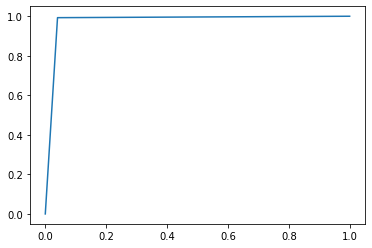

In [0]:
plt.figure()
plt.plot(fpr, tpr, label = "Logitistic Regression (l1) {}".format(l1_ROC_auc))
plt.show()

### Naive Bayes Classifier

#### Here we use:

$𝑃𝑟(𝑌=1|𝑋)=\frac{𝑃𝑟(𝑋|𝑌=1)𝑃𝑟(𝑌=1)}{𝑃𝑟(𝑋)}$

In [0]:
from sklearn.naive_bayes import GaussianNB

kf = KFold(random_state=0)

nb_clf = GaussianNB()

results = cross_val_score(nb_clf, X_train, y_train, cv = kf)
results
results.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9226945412311267

In [0]:
from sklearn.naive_bayes import GaussianNB

kf = KFold(n_splits = 5, random_state=0)

nb_clf = GaussianNB()

results = cross_val_score(nb_clf, X_train, y_train, cv = kf)
nb_pred = cross_val_predict(nb_clf, X_test, y_test, cv = kf)
results
results.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.9226945412311267

### B1. Confusion Matrix and ROC Curve

In [0]:
from sklearn.metrics import confusion_matrix

nb_cm = confusion_matrix(y_test, nb_pred)
nb_cm

array([[217,  32],
       [ 20, 258]])

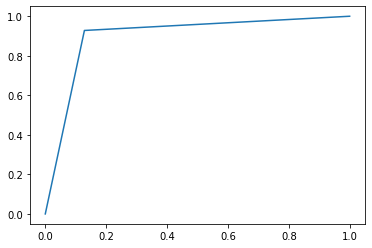

In [0]:
from sklearn.metrics import roc_auc_score, roc_curve

nb_ROC_auc = roc_auc_score(y_test, nb_pred)
fpr, tpr, threshold = roc_curve(y_test, nb_pred)

plt.figure()
plt.plot(fpr, tpr, label = "Logitistic Regression (l1) {}".format(l1_ROC_auc))
plt.show()

### A2. Support Vector Machines
### Use Support Vector Classifier

First we will rewrite our equation for the hyperplane as:
$𝐰⋅𝐱+𝑏=0$
 
For an observation  𝐱𝑖  with label  𝑦𝑖 , the distance to the hyperplane is:
$𝐷_𝑖=𝐰||𝐰||⋅𝐱𝑖+𝑏||𝐰||$
 
The margin is the distance to the closest observation:
$𝑀=min_𝑖𝐷_𝑖$

In [0]:
from sklearn.svm import SVC


svc_soft = SVC(kernel='linear', C=0.1)

svc_soft.fit(X_train, y_train)
svc_soft.score(X_test, y_test)

0.9772296015180265

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

kf = KFold(shuffle = True)

svc_soft = SVC(kernel='linear', C = 0.1)

results = cross_val_score(svc_soft, X_train, y_train, cv=kf)
soft_pred = cross_val_predict(svc_soft, X_test, y_test, cv = kf)
results

array([0.98780488, 0.99186992, 0.96341463, 0.98780488, 0.98367347])

### B1. Confusion Matrix and ROC Curve

In [0]:
from sklearn.metrics import confusion_matrix

soft_cm = confusion_matrix(y_test, soft_pred)
soft_cm

array([[231,  18],
       [  2, 276]])

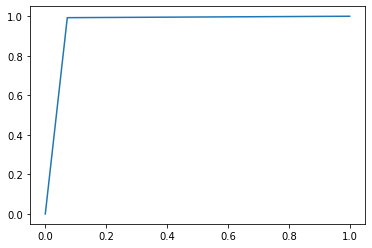

In [0]:
from sklearn.metrics import roc_auc_score, roc_curve

soft_ROC_auc = roc_auc_score(y_test, soft_pred)
fpr, tpr, threshold = roc_curve(y_test, soft_pred)

plt.figure()
plt.plot(fpr, tpr, label = "Logitistic Regression (l1) {}".format(soft_ROC_auc))
plt.show()

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(shuffle = True)

svc_hard = SVC(kernel='linear', C = 1E10)

results = cross_val_score(svc_hard, X_train, y_train, cv=kf)
hard_pred = cross_val_predict(svc_hard, X_test, y_test, cv = kf)
results

array([0.99593496, 1.        , 0.99593496, 0.99186992, 0.98367347])

### B1. Confusion Matrix and ROC Curve

In [0]:
from sklearn.metrics import confusion_matrix

hard_cm = confusion_matrix(y_test, hard_pred)
hard_cm

array([[246,   3],
       [  4, 274]])

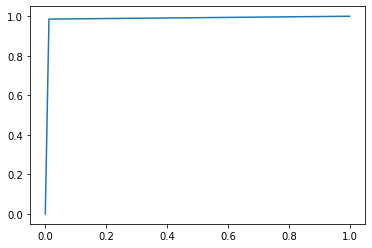

In [0]:
from sklearn.metrics import roc_auc_score, roc_curve

hard_ROC_auc = roc_auc_score(y_test, hard_pred)
fpr, tpr, threshold = roc_curve(y_test, hard_pred)

plt.figure()
plt.plot(fpr, tpr, label = "Logitistic Regression (l1) {}".format(hard_ROC_auc))
plt.show()

### Plot a 2D Representation

In [0]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict

In [0]:
# Get the weights
#svc_hard.coef_

In [0]:
X_train.shape

(1229, 9)

### A3 KNN

### KNN

#### Here, we use:
$𝑃𝑟(𝑌=𝑗|𝑋=𝑥0)=\frac{1}{𝐾}\sum_{𝑖∈𝑁_0}𝐼(𝑦_𝑖=𝑗)$

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits = 5, shuffle = True)

knn_clf = KNeighborsClassifier(n_neighbors = 5) # Default metric and p value is Euclidian distance

results = cross_val_score(knn_clf, X_train, y_train, cv=kf)
knn_euclidian_pred = cross_val_predict(knn_clf, X_test, y_test, cv = kf)
results

array([0.93902439, 0.93902439, 0.92682927, 0.91463415, 0.92653061])

### B1. Confusion Matrix and ROC Curve

In [0]:
from sklearn.metrics import confusion_matrix

knn_euclidian_cm = confusion_matrix(y_test, knn_euclidian_pred)
knn_euclidian_cm

array([[215,  34],
       [ 17, 261]])

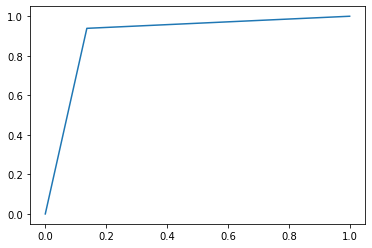

In [0]:
from sklearn.metrics import roc_auc_score, roc_curve

knn_euclidian_ROC_auc = roc_auc_score(y_test, knn_euclidian_pred)
fpr, tpr, threshold = roc_curve(y_test, knn_euclidian_pred)

plt.figure()
plt.plot(fpr, tpr, label = "Logitistic Regression (l1) {}".format(knn_euclidian_ROC_auc))
plt.show()

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits = 5, shuffle = True)

knn_manhattan_clf = KNeighborsClassifier(n_neighbors = 5, p = 1) # Manhattan

results = cross_val_score(knn_clf, X_train, y_train, cv=kf)
knn_manhttan_pred = cross_val_predict(knn_manhattan_clf, X_test, y_test, cv = kf)
results

array([0.93089431, 0.95121951, 0.91869919, 0.95934959, 0.92653061])

### B1. Confusion Matrix and ROC Curve

In [0]:
from sklearn.metrics import confusion_matrix

knn_manhttan_cm = confusion_matrix(y_test, knn_manhttan_pred)
knn_manhttan_cm

array([[212,  37],
       [ 17, 261]])

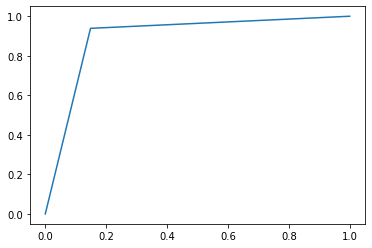

In [0]:
from sklearn.metrics import roc_auc_score, roc_curve

knn_manhttan_ROC_auc = roc_auc_score(y_test, knn_manhttan_pred)
fpr, tpr, threshold = roc_curve(y_test, knn_manhttan_pred)

plt.figure()
plt.plot(fpr, tpr, label = "Logitistic Regression (l1) {}".format(knn_manhttan_ROC_auc))
plt.show()

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score

# kf = KFold(n_splits = 5, shuffle = True)

knn_clf = KNeighborsClassifier(algorithm='brute',metric = "mahalanobis", metric_params={'V': np.cov(X_train)})
#results = cross_val_score(knn_clf, X_train, y_train, cv=kf)
knn_clf.fit(X_train, y_train)
knn_clf.score(X_test, y_test)

0.8975332068311196

### B1. Confusion Matrix and ROC Curve

In [0]:
from sklearn.metrics import confusion_matrix

knn_cm = confusion_matrix(y_test, knn_clf.predict(X_test))
knn_cm

array([[229,  20],
       [ 34, 244]])

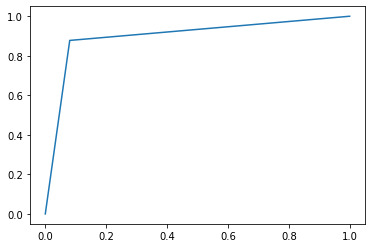

In [0]:
from sklearn.metrics import roc_auc_score, roc_curve

knn_ROC_auc = roc_auc_score(y_test, knn_clf.predict(X_test))
fpr, tpr, threshold = roc_curve(y_test, knn_clf.predict(X_test))

plt.figure()
plt.plot(fpr, tpr, label = "Logitistic Regression (l1) {}".format(knn_ROC_auc))
plt.show()

### B1. IMPORTANT NOTE

We cannot look too far into the confusion matrix, and the ROC curves because our Variance is too high to come up with an educated guess. Trying to interpret these results will only misinform us about the general patterns this kind of index makes. In order to reduce Variance we use Ensemble methods(such as a RandomForestClassifier). This will help us Bag and Boost. More than Boosting, we need to Bag because we reduced the number of relevant features using Lasso (L1) Regression. 

## B2. Feature Scoring/Selection
### Hyperparamter Tuning


In [0]:
# Create a dicitonary of models and parameters
models_params = {
    'logistic_regression_l1': {
        'model': LogisticRegression(solver = "liblinear", penalty = "l1"),
        'params': {
            'C': [1, 5, 10]
          }
    },
    'logistic_regression_l2': {
        'model': LogisticRegression(),
        'params': {
            'C': [1, 5, 10]
          }
    },
    'svc': {
        'model': SVC(gamma="auto"),
        'params': {
            'C': [1, 10, 20],
            'kernel': ['rbf', 'linear']
          }
    },
    'knn_simple': {
        'model': KNeighborsClassifier(),
        'params': {
            'p': [1, 2],
            'n_neighbors': [5, 10]
        }
    },
    'knn_mahalanobis': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [5, 10],
            'metric': ["mahalanobis"],
            "algorithm": ["brute"],
            "metric_params": [{"V": np.cov(X_train)}]
        }
    }
}

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

scores = []

for model_name, mp in models_params.items():
  clf = GridSearchCV(mp['model'], mp['params'], cv = 5, return_train_score = False)
  clf.fit(X_train, y_train)
  print(model_name)
  print(classification_report(y_test, clf.predict(X_test)))
  scores.append({
      'model': model_name,
      'best_score':clf.best_score_,
      'best_params': clf.best_params_
  })

  

logistic_regression_l1
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       249
           1       1.00      1.00      1.00       278

    accuracy                           1.00       527
   macro avg       1.00      1.00      1.00       527
weighted avg       1.00      1.00      1.00       527

logistic_regression_l2
              precision    recall  f1-score   support

          -1       0.99      1.00      0.99       249
           1       1.00      0.99      0.99       278

    accuracy                           0.99       527
   macro avg       0.99      0.99      0.99       527
weighted avg       0.99      0.99      0.99       527

svc
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00       249
           1       1.00      1.00      1.00       278

    accuracy                           1.00       527
   macro avg       1.00      1.00      1.00       527
weighted avg       1.00 

In [0]:
scores_df = pd.DataFrame(scores)
scores_df

,model,best_score,best_params
0,logistic_regression_l1,0.996748,{'C': 5}
1,logistic_regression_l2,0.993489,{'C': 10}
2,svc,0.993496,"{'C': 20, 'kernel': 'linear'}"
3,knn_simple,0.935689,"{'n_neighbors': 10, 'p': 2}"
4,knn_mahalanobis,0.908054,"{'algorithm': 'brute', 'metric': 'mahalanobis'..."


In [0]:
from sklearn.svm import SVC

# Make optimal classifier
clf = SVC(kernel="linear", C = 20, probability=True)

# Train
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9962049335863378

In [0]:
from sklearn.linear_model import LogisticRegression

# Make optimal classifier
log_clf = LogisticRegression(solver = "liblinear", penalty="l1", C = 1)

# Train
log_clf.fit(X_train, y_train)
log_clf.score(X_test, y_test)

0.9943074003795066

In [0]:
svc_prediction = clf.predict(X_test)
log_prediction = log_clf.predict(X_test)

In [0]:
svc_proba = clf.predict_proba(X_test)
log_proba = log_clf.predict_proba(X_test)

In [0]:
svc_proba_df = pd.DataFrame(svc_proba)
log_proba_df = pd.DataFrame(X_test)

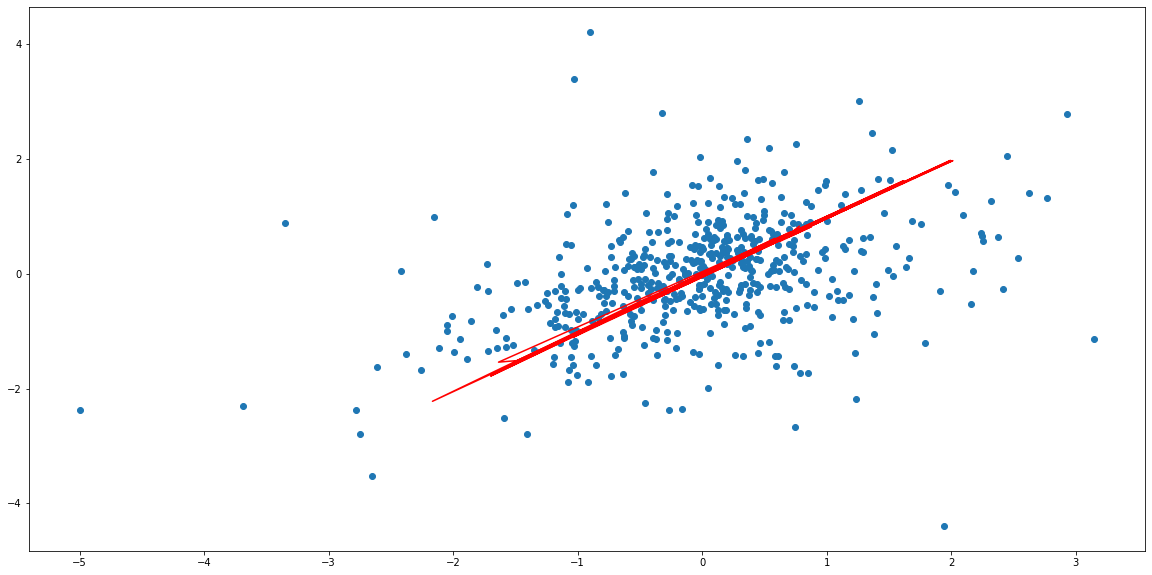

In [0]:
plt.clf
plt.figure(figsize=(20,10))

pts = X_test[:, 4:6]
x = pts.T[0]
_y = pts.T[1]

plt.scatter(x = x, y = _y) 
plt.plot(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], c="red")
plt.show()


### B3. Predict Probability

In [0]:
# SVC classifier
sigmoid_df = pd.DataFrame(data=X_test, columns=orig_column_names)
sigmoid_df.head()

def apply_sigmoid(row):
  val = clf.predict([row])
  return 1/(1+np.exp(-val))[0]  

def apply_sigmprob(row):
  row = row[:-1]
  val = clf.predict_proba([row])
  return val[0]  

sigmoid_df["s_fn"] = sigmoid_df.apply(lambda row: apply_sigmoid(row)  , axis=1)
sigmoid_df["s_prob"] = sigmoid_df.apply(lambda row: apply_sigmprob(row)  , axis=1)
sigmoid_df["s_prob_m1"] = sigmoid_df.s_prob.apply(lambda x : x[0])
sigmoid_df["s_prob_p1"] = sigmoid_df.s_prob.apply(lambda x : x[1])
sigmoid_df = sigmoid_df.drop("s_prob", axis=1)
sigmoid_df["actual_bet"] = sigmoid_df.apply(lambda x : 1 if x["s_prob_p1"] > x["s_prob_m1"] else 0, axis=1)
sigmoid_df["bet"] = sigmoid_df.s_prob_p1.apply(lambda x : 1 if x > .97 else 0) 
""" since the variance was very high, it's difficult to see which bets will happened and which won't. 
Hence the threshold is set to 97% to make it visually evident as to which bets will go through
and which will not go through
"""
sigmoid_df.head()

,open,high,low,close,return,momentum,SMA,EMA,std,s_fn,s_prob_m1,s_prob_p1,actual_bet,bet
0,-0.134271,-0.170022,-0.202444,-0.252587,-1.129812,-0.420012,-0.159819,-0.179758,0.622279,0.268941,9.999999e-01,1.000000e-07,0,0
1,-0.063059,0.021209,-0.035417,0.067734,1.226092,-1.385716,0.138441,0.137382,1.068050,0.731059,3.000001e-14,1.000000e+00,1,1
2,-0.878325,-0.879199,-0.832806,-0.814370,0.646747,-0.798101,-0.738631,-0.777536,0.307078,0.731059,3.000001e-14,1.000000e+00,1,1
3,0.478881,0.440188,0.461012,0.435336,-0.391333,-0.458608,0.493856,0.502223,-0.552430,0.268941,9.999897e-01,1.029932e-05,0,0
4,0.116890,0.141345,0.181081,0.192653,0.700907,0.789086,0.095276,0.109361,-0.216596,0.731059,3.000001e-14,1.000000e+00,1,1


In [0]:
sigmoid_df[(sigmoid_df.actual_bet != sigmoid_df.bet) ].head()

,open,high,low,close,return,momentum,SMA,EMA,std,s_fn,s_prob_m1,s_prob_p1,actual_bet,bet
11,-0.941159,-0.992632,-0.901238,-0.939811,0.011135,-0.171891,-0.927455,-0.938970,-0.842147,0.731059,0.352082,0.647918,1,0
16,0.781180,0.733737,0.800065,0.788805,0.068389,0.355859,0.788294,0.774945,-0.901936,0.731059,0.081656,0.918344,1,0
57,0.665985,0.646590,0.679750,0.664062,-0.015678,2.034415,0.576573,0.580512,-0.362201,0.731059,0.396820,0.603180,1,0
65,0.797237,0.773430,0.802996,0.797180,0.001120,-0.380628,0.831283,0.817998,-1.301957,0.731059,0.445972,0.554028,1,0
90,0.630729,0.606721,0.633383,0.631437,0.007550,-0.612995,0.710170,0.687228,-0.868417,0.731059,0.444931,0.555069,1,0


In [0]:
g_df = sigmoid_df[sigmoid_df["bet"] > 0]
r_df = sigmoid_df[sigmoid_df["bet"] <= 0]
r_df.head()

,open,high,low,close,return,momentum,SMA,EMA,std,s_fn,s_prob_m1,s_prob_p1,actual_bet,bet
0,-0.134271,-0.170022,-0.202444,-0.252587,-1.129812,-0.420012,-0.159819,-0.179758,0.622279,0.268941,1.000000,1.000000e-07,0,0
3,0.478881,0.440188,0.461012,0.435336,-0.391333,-0.458608,0.493856,0.502223,-0.552430,0.268941,0.999990,1.029932e-05,0,0
5,0.493542,0.485878,0.413437,0.360489,-1.200755,-1.576338,0.562302,0.514082,-0.230549,0.268941,1.000000,1.000000e-07,0,0
11,-0.941159,-0.992632,-0.901238,-0.939811,0.011135,-0.171891,-0.927455,-0.938970,-0.842147,0.731059,0.352082,6.479177e-01,1,0
14,0.209220,0.149637,0.154880,0.118330,-0.839744,-0.232544,0.129043,0.153023,0.028571,0.268941,1.000000,1.000000e-07,0,0


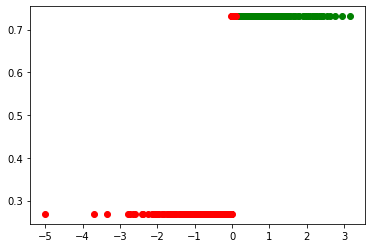

In [0]:
plt.scatter(x=g_df["return"], y=g_df["s_fn"], c="g")
plt.scatter(x=r_df["return"], y=r_df["s_fn"], c="r")

plt.show()

In [0]:
X_test_df = pd.DataFrame(X_test)
X_test_df.columns = orig_column_names
X_test_df = X_test_df[["return"]]
X_test_df["actual"] = y_test.values
X_test_df['predict'] = clf.predict(X_test)
X_test_df['g_col'] = np.where(X_test_df.actual==X_test_df.predict, 1, 0)
red_df = X_test_df[X_test_df.g_col != 1]
green_df = X_test_df[X_test_df.g_col == 1]
red_df

,return,actual,predict,g_col
57,-0.015678,-1,1,0
158,-0.013934,1,-1,0


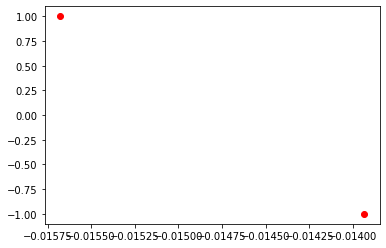

In [0]:
plt.scatter(x=red_df["return"], y=red_df["predict"], c="r")
plt.show() # SVM classifier - Wrongly predicted in a seaprate graph for highlighting purpose

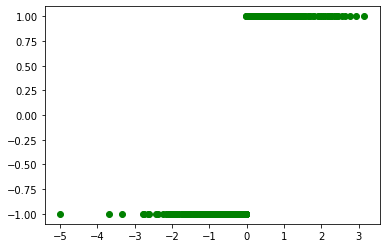

In [0]:
plt.scatter(x=green_df["return"], y=green_df["predict"], c="g")
plt.show() # SVM classifier - righhtly predicted

### B3. LOGIT cleassifier to illustrate prediction quality

In [0]:
X_test_df = pd.DataFrame(X_test)
X_test_df.columns = orig_column_names
X_test_df = X_test_df[["return"]]
X_test_df["actual"] = y_test.values
X_test_df['predict'] = log_clf.predict(X_test) #Logit classifier
X_test_df['g_col'] = np.where(X_test_df.actual==X_test_df.predict, 1, 0)
red_df = X_test_df[X_test_df.g_col != 1]
green_df = X_test_df[X_test_df.g_col == 1]
red_df

,return,actual,predict,g_col
57,-0.015678,-1,1,0
158,-0.013934,1,-1,0
408,-0.008316,1,-1,0


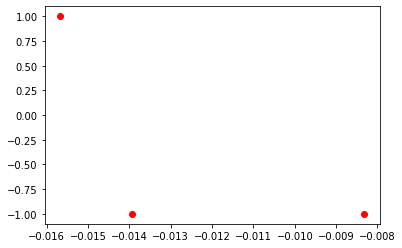

In [0]:
plt.scatter(x=red_df["return"], y=red_df["predict"], c="r")
plt.show() # Logit classifier - Wrongly predicted in a seaprate graph for highlighting purpose

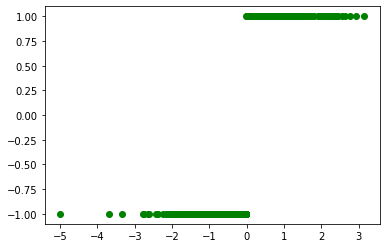

In [0]:
plt.scatter(x=green_df["return"], y=green_df["predict"], c="g")
plt.show() # Logit classifier - rightly predicted